# <center>Battle of the Neighbourhoods</center>
#### <center >City of San Francisco


## Introduction
#### Importing Libraries

In this project we use
- Folium
- Matplotlib
- Geopy
- Pandas,Numpy etc. . .

and along with 
- <b>Foursquare Map API</b>

In [28]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
print('Libraries imported.')
import matplotlib.pyplot as plt
import random

Libraries imported.


### Locating the City
We Get the location of the city of San Francisco using Geolocator()

In [3]:
address = 'San Francisco, SF'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
LAT = location.latitude
LON = location.longitude
print('The geograpical coordinate of San Francisco City are {}, {}.'.format(LAT, LON))
#The geograpical coordinate of San Francisco City are 37.7790262, -122.4199061.

The geograpical coordinate of San Francisco City are 37.7790262, -122.4199061.


### Generating Map
Generating Map of San Francisco using Folium

In [43]:
map_sf = folium.Map(location=[LAT, LON], zoom_start=14)

In [70]:
CLIENT_ID = 'JBREGZ4UNA53HX43WMAD4TQ2X2XJWMX5DPHEZEIZHQA0ACNP' # your Foursquare ID
CLIENT_SECRET = 'VNS40KF3V4MGSWWAV0IGQINZIGIT1EQKNCWBFPOS3QF1JMOJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

def RequestVenuesAt(latitude,longitude,category):
    LIMIT = 10
    category = "&categoryId="+category
    url = 'https://api.foursquare.com/v2/venues/explore?{}&client_id={}&client_secret={}&v={}&ll={},{}&limit={}'.format(
    category,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude,  
    LIMIT)
    return requests.get(url).json()

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def Res_to_DF(results):
    venues = results['response']['groups'][0]['items']
    ven = pd.json_normalize(venues) # flatten JSON
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    ven =ven.loc[:, filtered_columns]
    ven['venue.categories'] = ven.apply(get_category_type, axis=1)
    ven.columns = [col.split(".")[-1] for col in ven.columns]
    #print(ven.shape)
    return ven

def Bulk2DF (results):
    arraydf = []
    for data in results:
        arraydf.append(Res_to_DF(data))
    return arraydf

print("Defining Support Functions")

Defining Support Functions


### Gather Initial Points on Map


We first gather hospitals in the heart of the city (assuming it as a mandatory requirement)

In [39]:
hospt_results = RequestVenuesAt(LAT,LON,"4bf58dd8d48988d196941735")
hos_df=Res_to_DF(hospt_results)
hos_df

,name,categories,lat,lng
0,Hayes Surgery Center,Hospital,37.775869,-122.419868
1,Willow Surgery Center,Hospital,37.783105,-122.422345
2,One Medical,Hospital,37.773986,-122.422218
3,Saint Anthony Medical Clinic,Hospital,37.781795,-122.413004
4,Cmpc Imaging,Hospital,37.785867,-122.422005
5,CPMC Van Ness Campus,Hospital,37.785975,-122.422204
6,California Pacific Medical Center Van Ness Campus,Hospital,37.785972,-122.422349
7,Eye Surgery Center of San Francisco,Hospital,37.786768,-122.420744
8,KaunoSF,Hospital,37.777794,-122.410088
9,The Carlisle,Hospital,37.786383,-122.425836


In [44]:
source_df = hos_df
target_map=map_sf
coloring="red"

#-------------------------------------
for lat, lon, poi, cluster in zip(source_df['lat'], source_df['lng'], source_df['name'], source_df['categories']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
    [lat, lon],
    radius=4,
    popup=label,
    color=coloring,
    fill=True,
    fill_color=coloring,
    fill_opacity=0.7).add_to(target_map)
h_map=target_map
#-------------------------------------

h_map

### Scanning Vicinities of Initial Points


We then scan the nearby areas of the inital points for Schools, Eateries, Gyms 

In [52]:
gym_results   = school_results = food_results  =[]
i=0
for lat,lng in zip(hos_df['lat'], hos_df['lng']):
    print("Scanning Vicinity of ",i+1)
    food_results.append(   RequestVenuesAt(lat,lng,"4d4b7105d754a06374d81259"))
    school_results.append( RequestVenuesAt(lat,lng,"4bf58dd8d48988d13b941735"))
    gym_results.append(    RequestVenuesAt(lat,lng,"4bf58dd8d48988d175941735"))
    i+=1
print("Scan Complete")

Scanning Vicinity of  1
Scanning Vicinity of  2
Scanning Vicinity of  3
Scanning Vicinity of  4
Scanning Vicinity of  5
Scanning Vicinity of  6
Scanning Vicinity of  7
Scanning Vicinity of  8
Scanning Vicinity of  9
Scanning Vicinity of  10
Scan Complete


In [71]:
food_df = pd.concat(Bulk2DF(food_results))
school_df = pd.concat(Bulk2DF(school_results))
gym_df = pd.concat(Bulk2DF(gym_results))

In [45]:
source_df = food_df
target_map=h_map
coloring="orange"

#-------------------------------------
for lat, lon, poi, cluster in zip(source_df['lat'], source_df['lng'], source_df['name'], source_df['categories']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
    [lat, lon],
    radius=4,
    popup=label,
    color=coloring,
    fill=True,
    fill_color=coloring,
    fill_opacity=0.7).add_to(target_map)
hf_map=target_map
#-------------------------------------

# Map with Hospital and Foods
hf_map

In [46]:
source_df = school_df
target_map=hf_map
coloring="purple"

#-------------------------------------
for lat, lon, poi, cluster in zip(source_df['lat'], source_df['lng'], source_df['name'], source_df['categories']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
    [lat, lon],
    radius=4,
    popup=label,
    color=coloring,
    fill=True,
    fill_color=coloring,
    fill_opacity=0.7).add_to(target_map)
hfs_map=target_map
#-------------------------------------

# Map with Hospital and Foods and Schools
hfs_map

In [47]:
source_df = gym_df
target_map=hfs_map
coloring="green"

#-------------------------------------
for lat, lon, poi, cluster in zip(source_df['lat'], source_df['lng'], source_df['name'], source_df['categories']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
    [lat, lon],
    radius=4,
    popup=label,
    color=coloring,
    fill=True,
    fill_color=coloring,
    fill_opacity=0.7).add_to(target_map)
hfsg_map=target_map
#-------------------------------------

# Map with Hospital and Foods and Schools
hfsg_map

In [49]:
#New Map for All Necessities Together
map_sf_all = folium.Map(location=[LAT, LON], zoom_start=14,)
all_df = pd.concat([hos_df,school_df,food_df,gym_df])


source_df = all_df
target_map=map_sf_all
coloring="cadetblue"

#-------------------------------------
for lat, lon, poi, cluster in zip(source_df['lat'], source_df['lng'], source_df['name'], source_df['categories']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
    [lat, lon],
    radius=4,
    popup=label,
    color=coloring,
    fill=True,
    fill_color=coloring,
    fill_opacity=0.7).add_to(target_map)
map_sf_all=target_map
#-------------------------------------

# Map with all Necessities Together
map_sf_all

### Prepping Data for K-Means Clustering

We prepare the data for performing K-Means Clustering.

Since the Data we have is Lattitude and Longitude,
    we take the following steps to convert it to a simpler form
        - Subtract all values by mean of the dataset
        - Multiply all values by 1000 to make the value Easier to plot
        - store the Mean of the Dataset into 2 variables for later resubsitution

In [24]:
backdf= all_df.copy()
backdf.head()

backdf['lat']=backdf['lat'].subtract(backdf['lat'].mean())
backdf['lng']=backdf['lng'].subtract(backdf['lng'].mean())
backdf
backdf['lat']*=1000
backdf['lng']*=1000
backdf
all_meanlat = all_df['lat'].mean()
all_meanlng = all_df['lng'].mean()

### K-Means Clustering 
                     
We aim to make a suitable number of clusters and Ensure a proper output by this algorithm

    Clusters = 4 or above
    Source Data = Lattitude, Longitude

In [53]:
k_means = KMeans(init="k-means++", n_clusters=4, n_init=12,max_iter=10)
k_means

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10,
       n_clusters=4, n_init=12, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [54]:
X=backdf[['lat','lng']].to_numpy()
k_means.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10,
       n_clusters=4, n_init=12, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [55]:
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_


### Plotting Results of K-Means Clustering as ScatterPlot

We show the scatterplot of result after performing K-Means Clustering.
        
        Each Cluster is represented by a unique colour
        Each Cluster is marked with a Centroid (that will act as the selected Location)

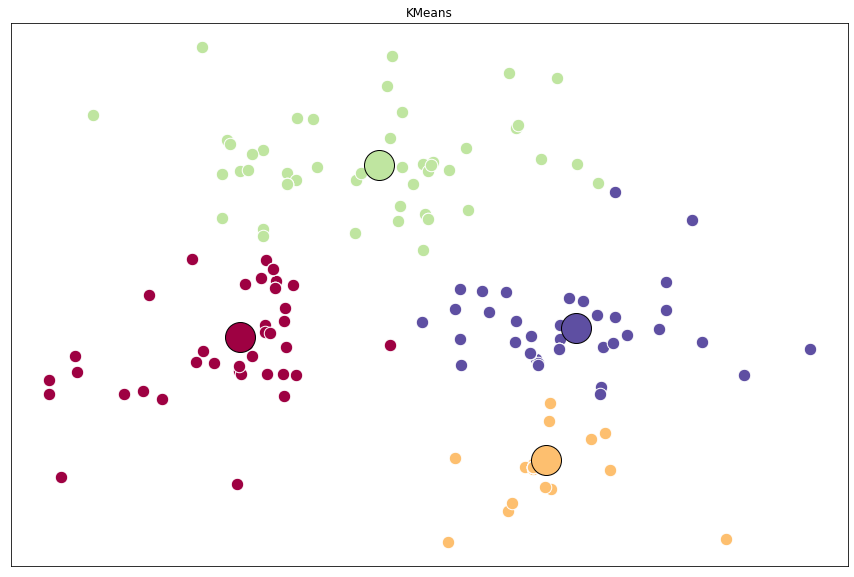

In [56]:
fig = plt.figure(figsize=(15, 10))

# the number of labels. We use set(k_means_labels) to get the
# unique labels.
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

# create a plot
ax = fig.add_subplot(1, 1, 1)

# loop through the data and plot the datapoints and centroids.
# k will range from 0-3, which will match the number of clusters in the dataset.
for k, col in zip(range(len([[4,4], [-2, -1], [2, -3], [1, 1]])), colors):

    # create a list of all datapoints, where the datapoitns that are 
    # in the cluster (ex. cluster 0) are labeled as true, else they are
    # labeled as false.
    my_members = (k_means_labels == k)
    
    # define the centroid, or cluster center.
    cluster_center = k_means_cluster_centers[k]
    
    # plot the datapoints with color col.
    ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='.',markersize=25)
    
    # plot the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=30)

# title of the plot
ax.set_title('KMeans')

# remove x-axis ticks
ax.set_xticks(())

# remove y-axis ticks
ax.set_yticks(())
# show the plot
plt.show()

# Conclusion


### Gathering results from Cluster

We now locate these points on the Map and Label them as Potential Locations

We recall, that we modified the dataset to suit the algorithm.

To revert back to the original form we perform the following steps,
    
    Each value is divided by 1000
    Each value is added with the previously stored Mean of Lattitude and Longitude

In [61]:
pos_locs = pd.DataFrame(data=k_means_cluster_centers,columns=['lat','lng'])
pos_locs=pos_locs.div(1000)
pos_locs=pos_locs - [all_meanlat,all_meanlng]
pos_locs

,lat,lng
0,-37.790574,122.417914
1,-37.779271,122.410265
2,-37.785433,122.428583
3,-37.778147,122.418480


### Locating on the Map

We the following calculated points on the Map

               lat	       lng
    	37.780095	-122.409962
    	37.786258	-122.428280
    	37.774954	-122.420631
    	37.787381	-122.420065

In [65]:
map_sf_locs = folium.Map(location=[LAT, LON], zoom_start=14)
lat_df=pos_locs['lat']*-1
lon_df=pos_locs['lng']*-1
target_map=map_sf_locs
coloring="blue"
for lat, lon in zip(lat_df, lon_df):
    label = folium.Popup("Possible Location")
    folium.CircleMarker(
    [lat, lon],
    radius=4,
    popup=label,
    color=coloring,
    fill=True,
    fill_color=coloring,
    fill_opacity=0.7).add_to(target_map)
map_sf_locs=target_map
map_sf_locs

### Exploring the Vicinities of the Selected Locations

We now explore the Vicinities of the 4 Selected Locations

In [78]:
def RequestVenues(latitude,longitude,category):
    LIMIT = 3
    category = "&categoryId="+category
    url = 'https://api.foursquare.com/v2/venues/explore?{}&client_id={}&client_secret={}&v={}&ll={},{}&limit={}'.format(
    category,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude,  
    LIMIT)
    return requests.get(url).json()

final_hos_results=[]
final_food_results=[]
final_school_results=[]
final_gym_results=[]
i=0
for lat,lng in zip(lat_df, lon_df):
    final_hos_results.append(RequestVenues(lat,lng,"4bf58dd8d48988d196941735"))
    final_food_results.append(RequestVenues(lat,lng,"4d4b7105d754a06374d81259"))
    final_school_results.append(RequestVenues(lat,lng,"4bf58dd8d48988d13b941735"))
    final_gym_results.append(RequestVenues(lat,lng,"4bf58dd8d48988d175941735"))
    i+=1
    print("Found nearby facilities of ",i)
print("Completed")


final_hos_df  =Bulk2DF(final_hos_results   )
final_food_df =Bulk2DF(final_food_results  )
final_sch_df  =Bulk2DF(final_school_results)
final_gym_df  =Bulk2DF(final_gym_results   )

Found nearby facilities of  1
Found nearby facilities of  2
Found nearby facilities of  3
Found nearby facilities of  4
Completed


In [73]:
type(Bulk2DF(final_hos_results   ))

list

### A few Facilities Available Near the Locations Selected

We list out the distances of the nearby Facilities

    For an Example we select only the First Location (pos_locs[0]) and search nearby

In [79]:
from math import radians, cos, sin, asin, sqrt 

def distance(lat1, lat2, lon1, lon2): 
    lon1 = radians(lon1) 
    lon2 = radians(lon2) 
    lat1 = radians(lat1) 
    lat2 = radians(lat2)  
    dlon = lon2 - lon1  
    dlat = lat2 - lat1 
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  
    c = 2 * asin(sqrt(a))  
    r = 6371
    return(c * r)

facilities_df = pd.concat([final_hos_df[0],final_sch_df[0],final_food_df[0],final_gym_df[0]])

In [110]:
list_of_dists=[]
lat_loc1 = pos_locs['lat'][0]*-1
lng_loc1 = pos_locs['lng'][0]*-1
for lat,lng in facilities_df[['lat','lng']].to_numpy():
    list_of_dists.append(distance(lat,lat_loc1,lng,lng_loc1))

In [112]:
facilities_df['distances_metres']=list_of_dists
facilities_df['distances_metres']=facilities_df['distances_metres']*1000

#### An Example with Distances to nearest Facilities

    We see that most of them are below 200 metres from the Proposed Location

In [117]:
print("Nearby Facilities and their Distances")
facilities_df

Nearby Facilities and their Distances


,name,categories,lat,lng,distances_metres
0,California Skin Institute - San Francisco - No...,Hospital,37.789348,-122.417545,140.155565
1,Saint Francis Hospital Outpatient Registration,Hospital,37.789608,-122.416921,138.452522
2,SFMH Radiology,Hospital,37.789637,-122.416571,157.433378
0,Soko Gakuen Japanese Language School,Language School,37.788453,-122.426564,795.872803
1,Grace Cathedral,Church,37.791666,-122.413348,419.168993
2,Sips n Sews,School,37.788127,-122.419243,296.135904
0,Mymy Coffee Shop,Diner,37.790833,-122.419118,109.606637
1,Crostini And Java,Café,37.789111,-122.417099,177.781797
2,Swan Oyster Depot,Seafood Restaurant,37.790931,-122.420759,253.080523
0,Uforia Studios,Gym / Fitness Center,37.790441,-122.420148,196.878076
